In [24]:
from __future__ import print_function
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from scipy import stats
import seaborn as sns
sns.set(style="white")

args = {
    'metadata':"../data/all_dnsv_metadata.csv",
    'dnsvs':"../data/all_dnsv.csv",
}

def change_width(ax, new_value):
    for patch in ax.patches:
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
all_meta_info = pd.read_csv(args['metadata'], index_col=0)
all_sv_info = pd.read_csv(args['dnsvs'])
all_sv_info.rename(columns = {'#chrom':'chrom'}, inplace = True)
all_meta_info["dn_snvs"] = all_meta_info["dn_snvs"].replace(np.nan, 0, regex=True)
all_sv_info["dn_snvs"] = all_sv_info["dn_snvs"].replace(np.nan, 0, regex=True)


autism_sv_info = all_sv_info[(all_sv_info['role'] == "proband") 
    & (all_sv_info['pos'] > 1)
    & (all_sv_info['mosaic'] == False)]

sib_sv_info = all_sv_info[(all_sv_info['role'] != "proband")
    & (all_sv_info["father"] != ".") 
    & (all_sv_info["mother"] != ".")
    & (all_sv_info['pos'] > 1)
    & (all_sv_info['mosaic'] == False)]

print(len(autism_sv_info))
print(len(sib_sv_info))

486
379


/Users/jon/miniconda3/envs/main/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [25]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [26]:
#go through all the samples in the all_meta_info and count the number of svs of each type they have
# svtypes = ["DEL","DUP","INS","CPX","CTX","INV"]
sv_counts = {
    "DEL": [],
    "DUP": [],
    "INS": [],
    "MEI": [],
    "CPX": [],
    "CTX": [],
    "INV": [],
    "all_sv":[],
    "paternal":[],
    "maternal":[],
}

mei_types = ["ALU","LINE1","SVA"]
for i,sample in enumerate(all_meta_info.index): 
    sample_svs = all_sv_info[all_sv_info["sample"] == sample]        
    sample_sv_counts = {
        "DEL": 0,
        "DUP": 0,
        "INS": 0,
        "MEI": 0,
        "CPX": 0,
        "CTX": 0,
        "INV": 0,
        "all_sv": 0,
        "paternal": 0,
        "maternal": 0
    }
    for idx,row in sample_svs.iterrows():
        if (row['mosaic'] == True) or (row['pos'] <= 0):
            continue
        sample_sv_counts['all_sv'] += 1

        svtype = row['svtype']
        if (row.loc['pred_mechanism'] in mei_types) or (svtype in mei_types):
            svtype = "MEI"
        sample_sv_counts[svtype] += 1
        
        if row['parent_of_origin'] == "father":
            sample_sv_counts['paternal'] += 1
        elif row['parent_of_origin'] == "mother":
            sample_sv_counts['maternal'] += 1
        
    for svtype in sv_counts:
        sv_counts[svtype].append(sample_sv_counts[svtype])
        
for svtype in sv_counts:
    all_meta_info[svtype] = sv_counts[svtype]

with open("../data/dnsv_dataframe.csv", 'w') as info_file:
        print(all_meta_info.to_csv(header=True), file=info_file)
print("done")

done


In [27]:
#analyze proband v sib size patterns and write out the results
from statsmodels.stats.multitest import multipletests
from copy import copy

#count the number of SVs in each size bin
size_bins = [10,100,1000,10000,100000,1000000]
proband_dnm_len_counts = [0,0,0,0,0,0]
for length in autism_sv_info['svlen'][
              (autism_sv_info['svtype'] != "INS")
              & (autism_sv_info['svtype'] != "ALU")
              & (autism_sv_info['svtype'] != "L1")
              & (autism_sv_info['svtype'] != "SVA")
              & (autism_sv_info['pos'] != 1)
    ]:
    for i,size_bin_start in enumerate(size_bins):
        if len(size_bins) > i+1:            
            if (length < size_bins[i]) or (size_bins[i] <= length < size_bins[i+1]):
                proband_dnm_len_counts[i] += 1               
                break
        elif len(size_bins) == i+1:
            proband_dnm_len_counts[i] += 1
sibling_dnm_len_counts = [0,0,0,0,0,0]
for length in sib_sv_info['svlen'][
            (sib_sv_info['svtype'] != "INS")
            & (sib_sv_info['svtype'] != "ALU")
            & (sib_sv_info['svtype'] != "L1")
            & (sib_sv_info['svtype'] != "SVA")
            & (sib_sv_info['pos'] != 1)
    ]:
    for i,size_bin_start in enumerate(size_bins):
        if len(size_bins) > i+1:            
            if (length < size_bins[i]) or (size_bins[i] <= length < size_bins[i+1]):
                sibling_dnm_len_counts[i] += 1               
                break
        elif len(size_bins) == i+1:
            sibling_dnm_len_counts[i] += 1
            
#format data for tidyverse
size_counts_dict = {}
size_counts_dict['Probands'] = (proband_dnm_len_counts)
size_counts_dict['Siblings'] = (sibling_dnm_len_counts)
size_counts_dict['Proband rate'] = [x/sum(proband_dnm_len_counts) for x in proband_dnm_len_counts]
size_counts_dict['Sibling rate'] = [x/sum(sibling_dnm_len_counts) for x in sibling_dnm_len_counts]

size_counts = pd.DataFrame.from_dict(size_counts_dict)


pvals = []
for i,val in enumerate(size_counts['Probands']):
    oddsratio, pvalue = stats.fisher_exact([
        [
            size_counts['Probands'][i],
            size_counts['Siblings'][i]
        ],
        [
            sum(size_counts['Probands']),
            sum(size_counts['Siblings'])
        ]
    ])
    pvals.append(pvalue)

sizes = ['<-100','100-1Kb','1Kb-10Kb','10Kb-100Kb','100Kb-1Mb','1Mb->']
size_counts['padj'] = multipletests(pvals, method="fdr_bh", alpha=0.05)[1]
size_counts['Sizes'] = sizes       
with open("../data/size_freqs.csv", 'w') as sizes_file:
    print(size_counts.to_csv(index=False), file=sizes_file)
print("done")

done


,Counts,Affected status,SV type
0,254,Probands,DEL
1,120,Probands,DUP
2,60,Probands,ALU
3,18,Probands,CPX
4,11,Probands,LINE1
5,10,Probands,SVA
6,6,Probands,INS
7,5,Probands,INV
8,2,Probands,CTX
9,202,Unaffected,DEL


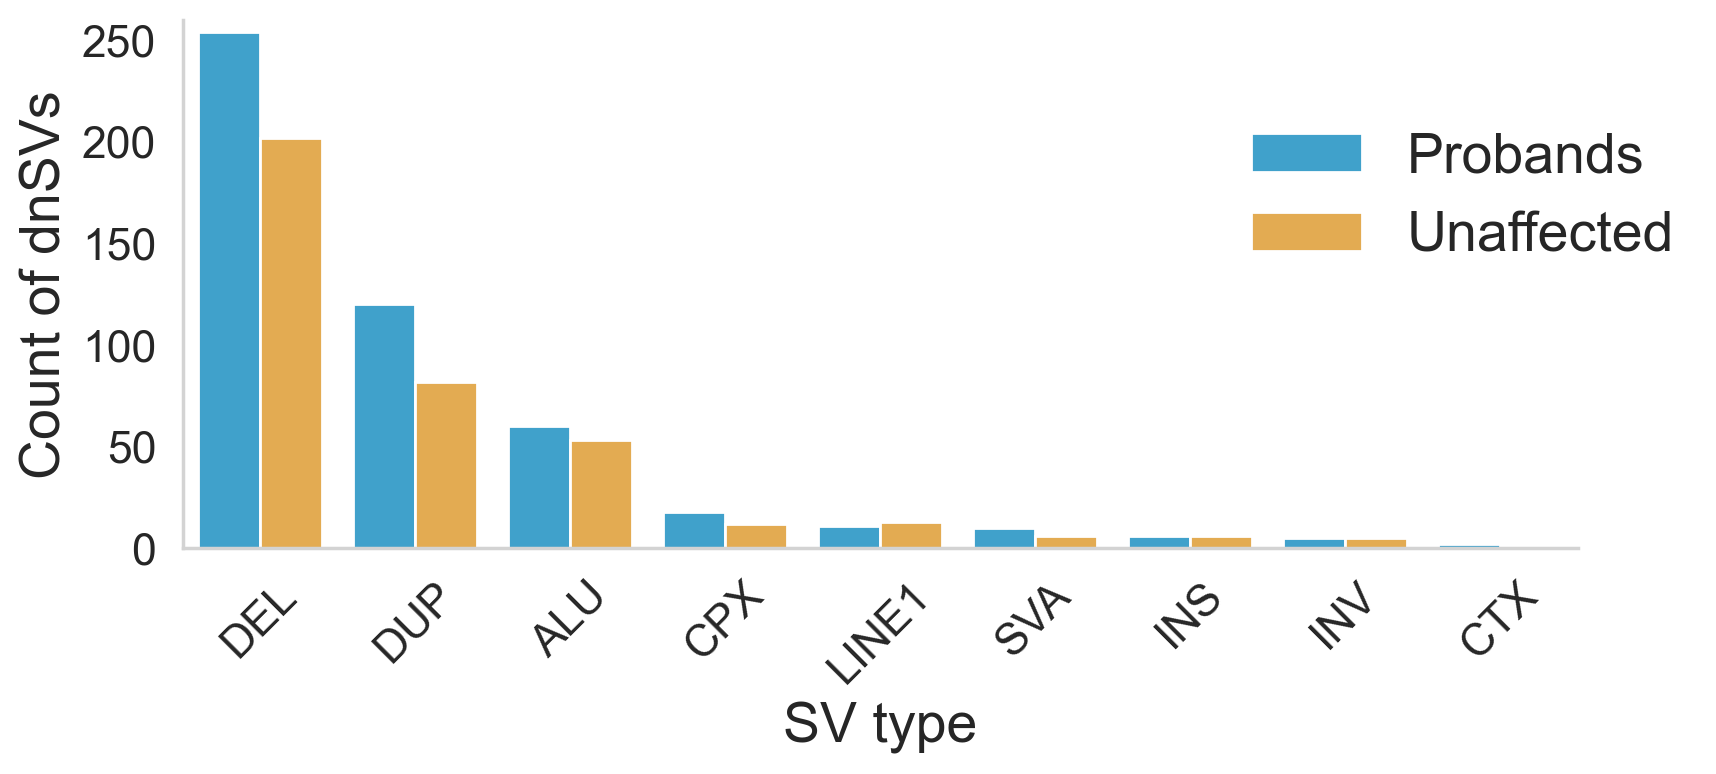

In [28]:
#Figure 1: dnSV type distribution
###############################################################################################################
counts = []
affected_status = []
svtypes = []
statuses = ["Probands","Unaffected"]
for i,countlist in enumerate([autism_sv_info.svtype.value_counts(),sib_sv_info.svtype.value_counts()]):
    for j,count in enumerate(countlist):
        counts.append(count)
        svtypes.append(countlist.index[j])
        affected_status.append(statuses[i])

counts_df = pd.DataFrame({
    'Counts':counts,
    "Affected status": affected_status,
    "SV type": svtypes
})

###############################################################################################################
fig, ax = plt.subplots(figsize=(9, 3.5),dpi=200)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
# fig.suptitle("Counts of dnSVs by type")
sns.set(style="white")
sns.barplot(
    ax=ax,
    data=counts_df,
    x="SV type",
    y="Counts",
    hue="Affected status",
    palette=['#29AAE2',"#FBB03A"],
);
ax.legend(loc=[.75,.5], frameon=False, fontsize=20)

change_width(ax, .4)
ax.set_ylabel("Count of dnSVs", fontsize=20)
ax.set_xlabel("SV type", fontsize=20)
ax.set_ylim(0,260)

for spine in ax.spines.values():
        spine.set_edgecolor('lightgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("../plots/fig1.png")
display(counts_df)

0.0007577821870376632
486 2363 379 2372
0.20567075751163774 0.15978077571669477


/Users/jon/miniconda3/envs/main/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


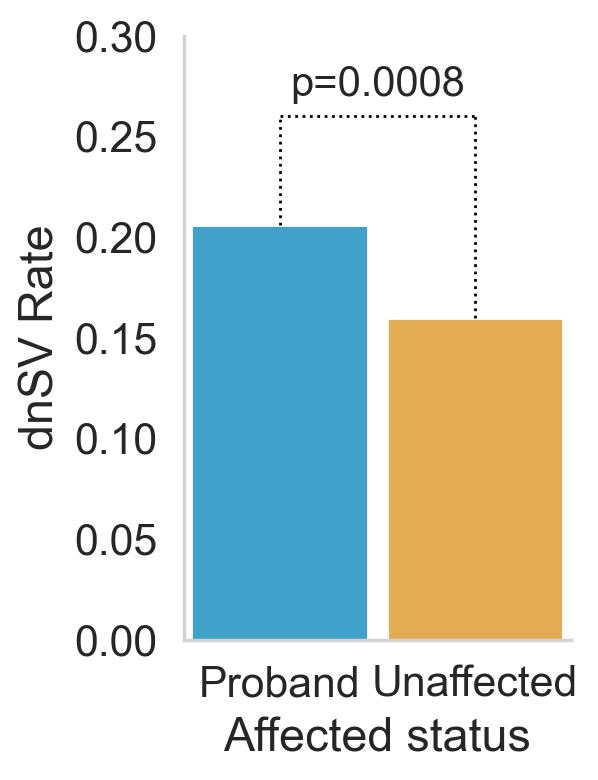

In [29]:
#Figure 2A: dnSV rate vs ASD status
###############################################################################################################
size_counts_dict = {}
proband_count = len(all_meta_info[(all_meta_info['role'] == "proband")])

proband_dnm_count = len(autism_sv_info)
sib_count = len(all_meta_info[(all_meta_info['role'] != "proband") 
    & (all_meta_info['father'] != ".")
    & (all_meta_info['mother'] != ".")
])
sib_dnm_count = len(sib_sv_info)

size_counts_dict['dnSV Rate'] = [proband_dnm_count/proband_count,sib_dnm_count/sib_count]
size_counts_dict['Affected status'] = ["Proband","Unaffected"]
size_counts = pd.DataFrame.from_dict(size_counts_dict)

oddsratio, pvalue = stats.fisher_exact([[proband_dnm_count,sib_dnm_count],[proband_count,sib_count]])
print(pvalue)
pval_str = "{:.4f}".format(pvalue)
sns.set(style="white",font_scale=1.4)

fig, ax = plt.subplots(figsize=(2.5, 4),dpi=200)
barplot = sns.barplot(
    x='Affected status', 
    y='dnSV Rate', 
    data=size_counts, 
    ax=ax, 
    palette=['#29AAE2','#FBB03A'],
)
change_width(ax, .90)

ax.plot([0,1],[0.26, 0.26],
       linewidth=1, color="black",linestyle='dotted')
ax.plot([0,0],[size_counts["dnSV Rate"][(size_counts["Affected status"] == "Proband") ], 0.26],
        linewidth=1, color="black",linestyle='dotted')
ax.plot([1,1],[size_counts["dnSV Rate"][(size_counts["Affected status"] == "Unaffected") ], 0.26], 
        linewidth=1, color="black",linestyle='dotted')
ax.text(.5, 0.27, "p="+pval_str, fontsize=15, horizontalalignment='center')
ax.set_ylim(0,.3)

for spine in ax.spines.values():
        spine.set_edgecolor('lightgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("../plots/fig2A.png")

print(proband_dnm_count,proband_count,sib_dnm_count,sib_count)
print(proband_dnm_count/proband_count,sib_dnm_count/sib_count)

group dad mom total
Probands: 125 43 168
Sibs: 66 34 100


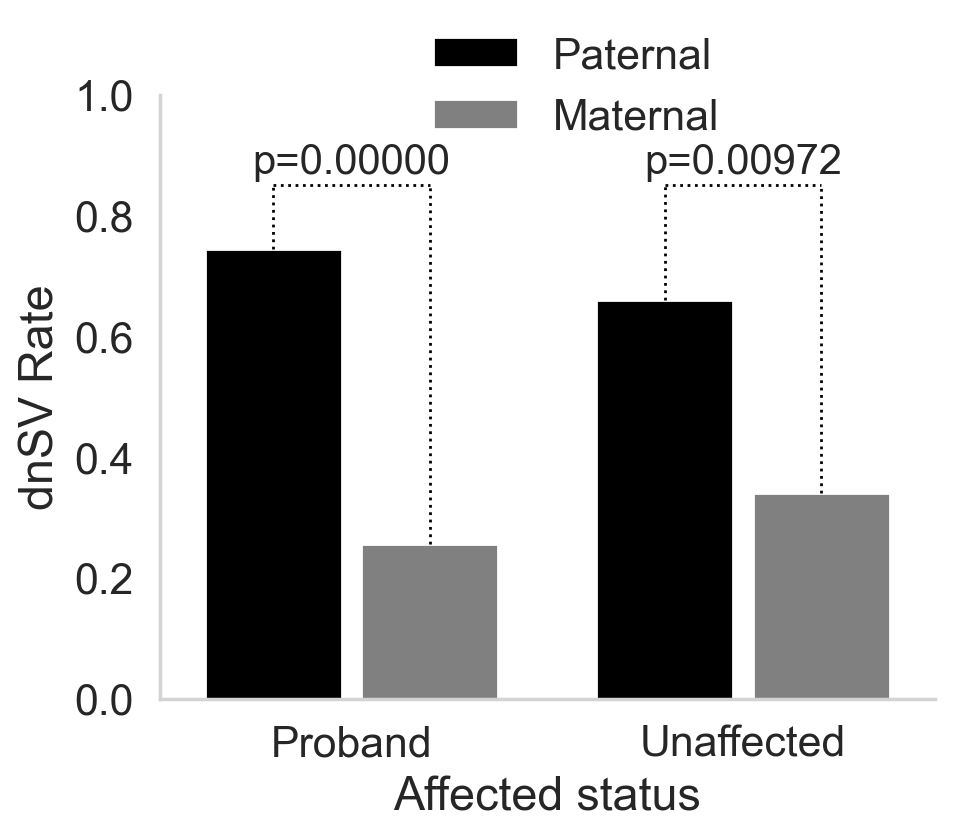

In [30]:
#Figure 2B: Phased paternal vs maternal dnSV rates 
###############################################################################################################
#paternal vs maternal in probands, phased only
proband_phased_size_counts_dict = {}
dad_count = len(autism_sv_info[(autism_sv_info['parent_of_origin'] == "father")])
mom_count = len(autism_sv_info[(autism_sv_info['parent_of_origin'] == "mother")])
proband_dnm_count = dad_count+mom_count
print("group", "dad","mom","total")
print("Probands:", dad_count, mom_count, proband_dnm_count)

proband_phased_size_counts_dict['dnSV Rate'] = [dad_count/proband_dnm_count,mom_count/proband_dnm_count]
proband_phased_size_counts_dict['Parent of origin'] = ["Paternal","Maternal"]

proband_phased_size_counts = pd.DataFrame.from_dict(proband_phased_size_counts_dict)

sns.set(style="white", font_scale=1.4)

oddsratio, pvalue = stats.fisher_exact([[dad_count,mom_count],[proband_dnm_count,proband_dnm_count]])
proband_pval_str = "{:.5f}".format(pvalue)

########################################################################################################################
#paternal vs maternal in siblings, phased only
sibling_phased_size_counts_dict = {}
dad_count = len(sib_sv_info[(sib_sv_info['parent_of_origin'] == "father")])
mom_count = len(sib_sv_info[(sib_sv_info['parent_of_origin'] == "mother")])

sibling_dnm_count = dad_count+mom_count
print("Sibs:", dad_count, mom_count, sibling_dnm_count)

sibling_phased_size_counts_dict['dnSV Rate'] = [dad_count/sibling_dnm_count,mom_count/sibling_dnm_count]
sibling_phased_size_counts_dict['Parent of origin'] = ["Paternal","Maternal"]

sibling_phased_size_counts = pd.DataFrame.from_dict(sibling_phased_size_counts_dict)

oddsratio, pvalue = stats.fisher_exact([[dad_count,mom_count],[sibling_dnm_count,sibling_dnm_count]])
sib_pval_str = "{:.5f}".format(pvalue)

########################################################################################################################
fig, ax = plt.subplots(figsize=(5,4), dpi=200)
phased_size_counts = pd.concat([proband_phased_size_counts,sibling_phased_size_counts])
phased_size_counts['Affected status'] = ["Proband", "Proband","Unaffected", "Unaffected"]

sns.barplot(
    ax=ax,
    data=phased_size_counts,
    x="Affected status",
    y="dnSV Rate",
    hue="Parent of origin",
    palette=['black','grey'],
)
ax.legend(loc=[.33,.9], frameon=False)
ax.set_ylim(0,1)

ax.plot([-0.2,0.2],[0.85, 0.85], linewidth=1, color="black",linestyle='dotted')
ax.plot([-0.2,-0.2],
        [phased_size_counts["dnSV Rate"][(phased_size_counts["Affected status"] == "Proband") & (phased_size_counts["Parent of origin"] == "Paternal")], 0.85],
        linewidth=1, color="black",linestyle='dotted')
ax.plot([0.2,0.2],
        [phased_size_counts["dnSV Rate"][(phased_size_counts["Affected status"] == "Proband") & (phased_size_counts["Parent of origin"] == "Maternal")], 0.85], 
        linewidth=1, color="black",linestyle='dotted')
ax.text(0, 0.87, "p="+proband_pval_str, fontsize=15, horizontalalignment='center')

ax.plot([0.8,1.2],[0.85, 0.85], linewidth=1, color="black",linestyle='dotted')
ax.plot([0.8,0.8],
        [phased_size_counts["dnSV Rate"][(phased_size_counts["Affected status"] == "Unaffected") & (phased_size_counts["Parent of origin"] == "Paternal")], 0.85], 
        linewidth=1, color="black", linestyle='dotted')
ax.plot([1.2,1.2],
        [phased_size_counts["dnSV Rate"][(phased_size_counts["Affected status"] == "Unaffected") & (phased_size_counts["Parent of origin"] == "Maternal")], 0.85], 
        linewidth=1, color="black",linestyle='dotted')
ax.text(1, 0.87, "p="+sib_pval_str, fontsize=15, horizontalalignment='center')
change_width(ax, .35)

for spine in ax.spines.values():
        spine.set_edgecolor('lightgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.savefig("../plots/fig2B.png")

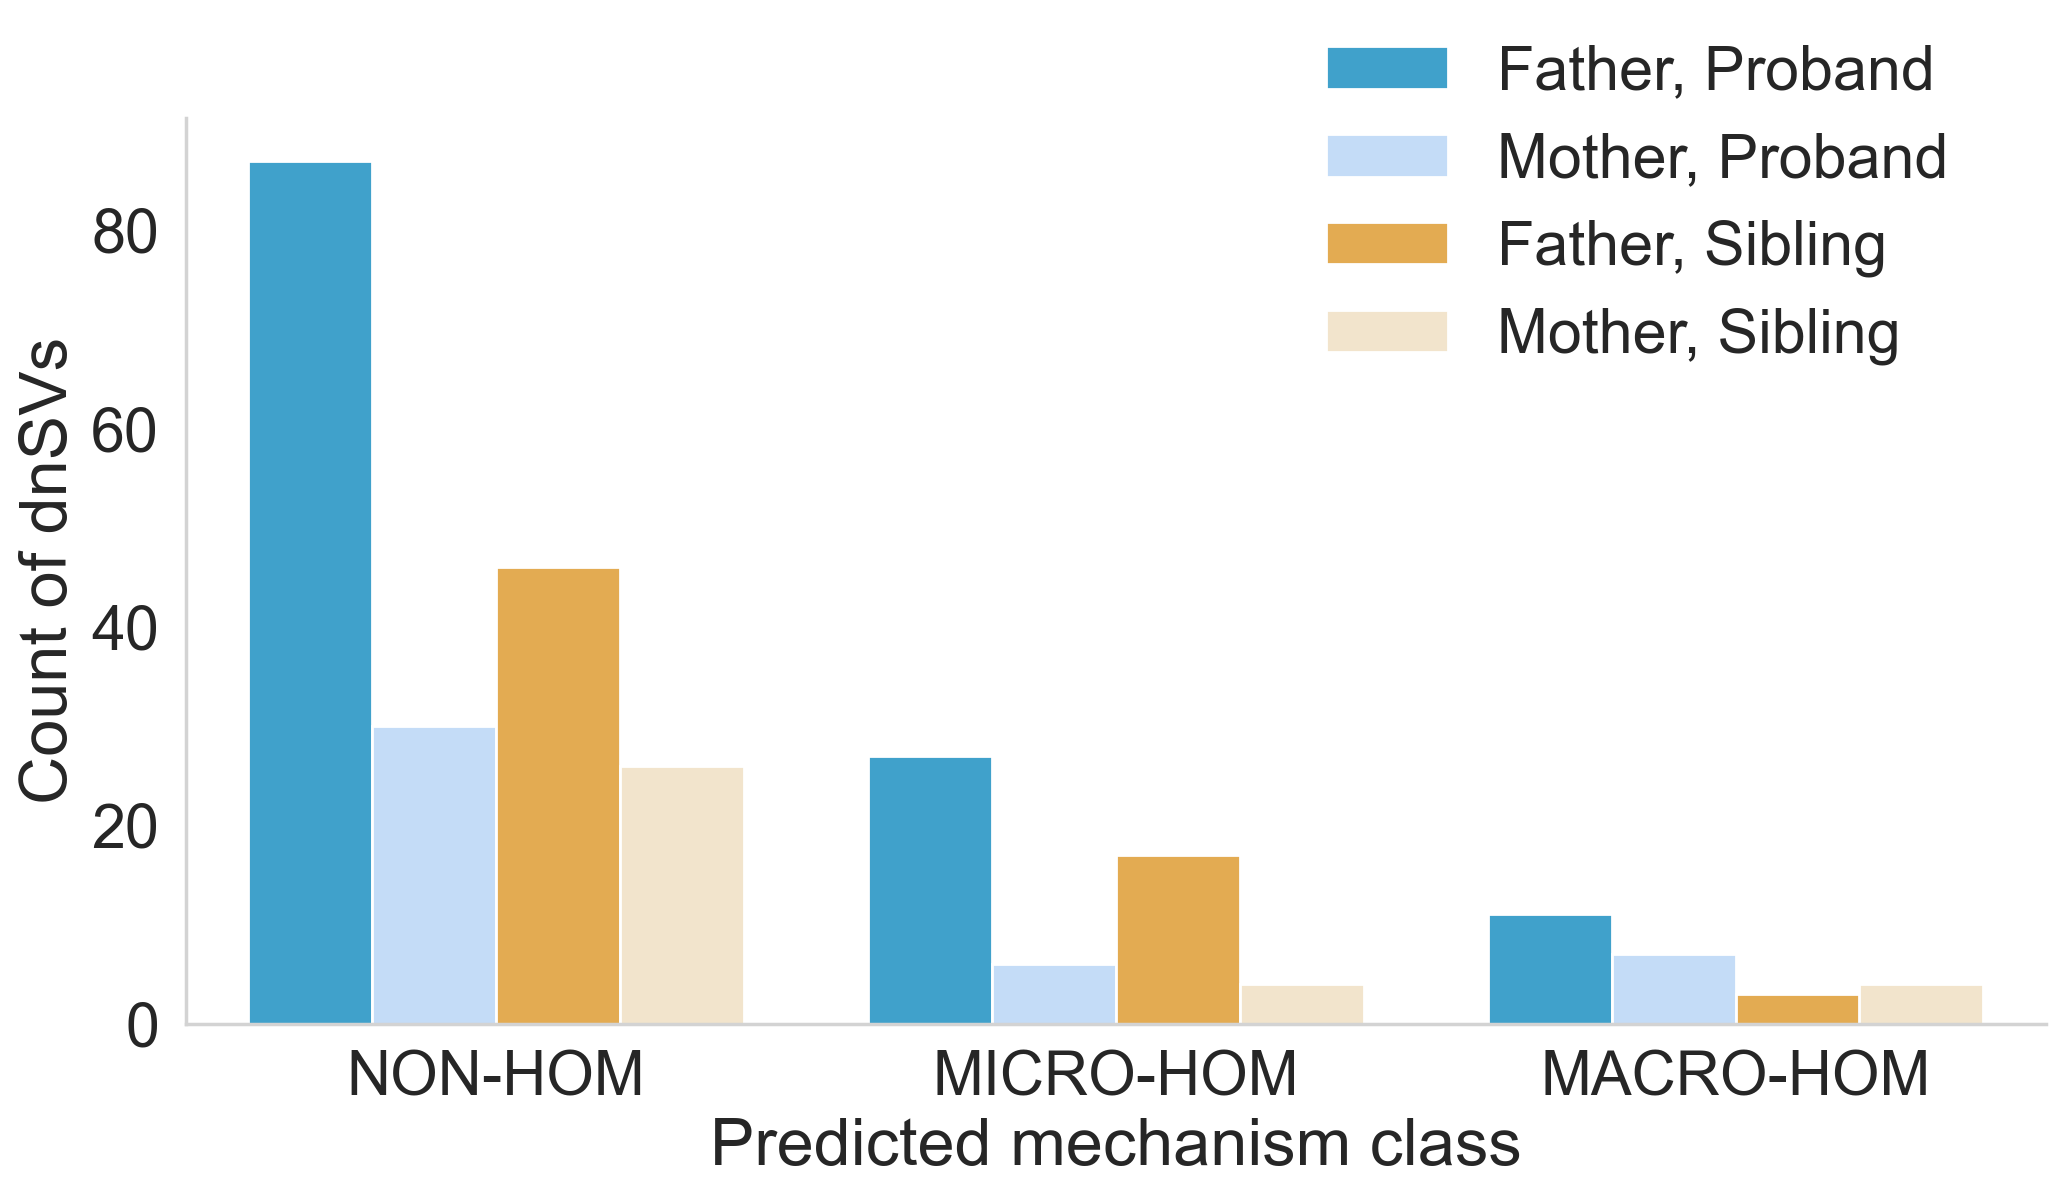

In [31]:
#Figure 4A: Phased dnSV by breakpoint homology class
###############################################################################################################
counts = []
fractions = []
parent_of_origin = []
affected_group = []
mechanisms = []
parent_and_status = []
for parent in ["mother", "father"]:
    for i,affected_group_df in enumerate([autism_sv_info, sib_sv_info]):
        for mechanism,count in affected_group_df[affected_group_df['parent_of_origin'] == parent].pred_mechanism.value_counts().iteritems():
            if mechanism in ["LINE1","SVA","ALU","INS"]:
                continue
            num_group_svs = len(affected_group_df[affected_group_df['parent_of_origin'] == parent])
            counts.append(count)
            fractions.append(count/num_group_svs)
            mechanisms.append(mechanism)
            parent_of_origin.append(parent)
            affected = "Proband" if i==0 else "Sibling"
            affected_group.append(affected)
            parent_and_status.append(parent[0].upper() + parent[1:]+", "+affected)
            

mech_counts_df = pd.DataFrame({
    'Fractions':fractions,
    'Counts':counts,
    "Affected status": affected_group,
    "Mechanism": mechanisms,
    "Parent of origin": parent_of_origin,
    "Parent & status": parent_and_status
})
mech_counts_df.sort_values(by=['Affected status', "Parent of origin"], inplace=True, ascending=True)

sns.set(style="white", font_scale = 2)

#################################################################################################
fig, ax = plt.subplots(figsize=(12, 6),dpi=200)
# fig, ax = plt.subplots(figsize=(8, 4),dpi=200)

sns.barplot(
    ax=ax,
    data=mech_counts_df,
    x="Mechanism",
    y="Counts",
    hue="Parent & status",
    palette=['#29AAE2','#bbdcffff','#FBB03A','#f8e5c6ff'],
);
ax.set_ylabel("Count of dnSVs", fontsize=24)
ax.set_xlabel("Predicted mechanism class", fontsize=24)

for spine in ax.spines.values():
        spine.set_edgecolor('lightgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc=[.6,.7], frameon=False, fontsize=22)

fig.savefig("../plots/fig4A.png")

[254, 2363, 202, 2271]

[120, 2363, 82, 2271]

[60, 2363, 53, 2271]

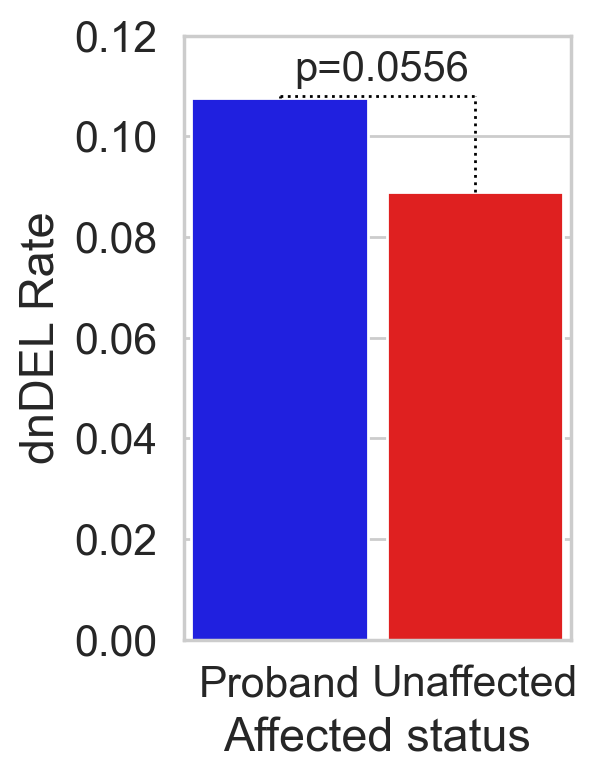

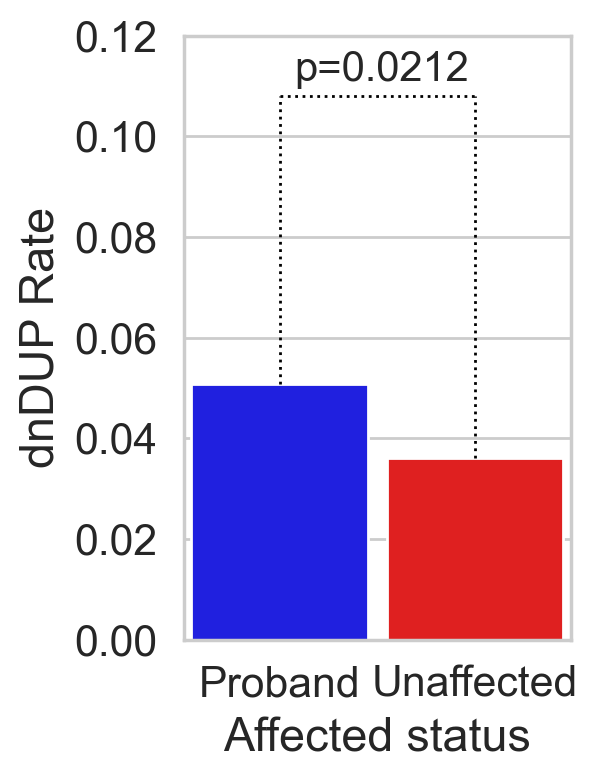

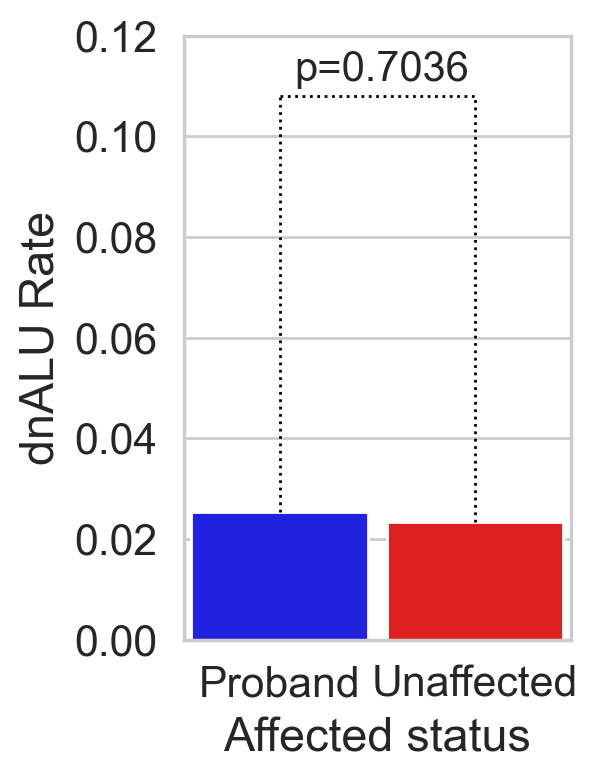

In [32]:
#Supplemental Figure 2: dnSV rates by type
#################################################################################################
proband_count = len(all_meta_info[(all_meta_info['role'] == "proband")])
sib_count = len(all_meta_info[(all_meta_info['role'] == "sib") ])

for svtype in autism_sv_info.svtype.unique():
    proband_sv_subset = autism_sv_info[autism_sv_info["svtype"] == svtype]
    sib_sv_subset = sib_sv_info[sib_sv_info["svtype"] == svtype]
    if len(proband_sv_subset) > 20 and len(sib_sv_subset) > 20:
        size_counts_dict = {}       

        proband_dnm_count = len(proband_sv_subset)
        sib_dnm_count = len(sib_sv_subset)
        yname = "dn"+svtype+" Rate"

        size_counts_dict[yname] = [proband_dnm_count/proband_count,sib_dnm_count/sib_count]
        size_counts_dict['Affected status'] = ["Proband","Unaffected"]
        size_counts = pd.DataFrame.from_dict(size_counts_dict)
        display([proband_dnm_count,proband_count,sib_dnm_count,sib_count])

        oddsratio, pvalue = stats.fisher_exact([[proband_dnm_count,sib_dnm_count],[proband_count,sib_count]])
        
        pval_str = "{:.4f}".format(pvalue)
        sns.set(style="whitegrid",font_scale=1.4)

        fig, ax = plt.subplots(figsize=(2.5, 4),dpi=200)
        barplot = sns.barplot(x='Affected status', y=yname, data=size_counts, ax=ax, palette=["blue","red"])
        ylim = max(size_counts[yname]) *1.2
        ylim = 0.12
        
        change_width(ax, .90)
        drop_by = ylim*0.1
        ax.plot([0,1],[ylim-drop_by, ylim-drop_by],
               linewidth=1, color="black",linestyle='dotted')
        ax.plot([0,0],[size_counts[yname][(size_counts["Affected status"] == "Proband") ], ylim-drop_by],
                linewidth=1, color="black",linestyle='dotted')
        ax.plot([1,1],[size_counts[yname][(size_counts["Affected status"] == "Unaffected") ], ylim-drop_by], 
                linewidth=1, color="black",linestyle='dotted')
        ax.text(ylim+.4, ylim-(drop_by-0.003), "p="+pval_str, fontsize=15, horizontalalignment='center')
        ax.set_ylim(0,ylim)
        fig.savefig("../plots/supp-fig2-{}.png".format(svtype))   

In [33]:
print("\n#################################################################################\n")
sib_count = len(all_meta_info[(all_meta_info['father'] != '.') & (all_meta_info['mother'] != '.') & (all_meta_info['role'] != "proband")])
proband_count = len(all_meta_info[(all_meta_info['father'] != '.') & (all_meta_info['mother'] != '.') & (all_meta_info['role'] == "proband")])
print ("Proband dnSV rate:", len(autism_sv_info) / proband_count)
print ("Sibling dnSV rate:", len(sib_sv_info) / sib_count)

print("Total dnSV count", len(autism_sv_info) + len(sib_sv_info))

print("\n#################################################################################\n")

sfari_sib_count = len(all_meta_info[(all_meta_info['father'] != '.') & (all_meta_info['mother'] != '.') & (all_meta_info['role'] == "sib") & (all_meta_info['project'] == "SFARI")])
print("SFARI sib count",sfari_sib_count)
proband_count = len(all_meta_info[(all_meta_info['father'] != '.') & (all_meta_info['mother'] != '.') & (all_meta_info['role'] == "proband")])
print("SFARI proband count: ",proband_count)
print("\n#################################################################################\n")


ceph_total_count = len(all_meta_info[(all_meta_info['project'] == "CEPH")])
ceph_sib_count = len(all_meta_info[(all_meta_info['father'] != ".") & 
    (all_meta_info['mother'] != ".") & (all_meta_info['project'] == "CEPH")])
print("CEPH sib count",ceph_sib_count)
print("CEPH total count",ceph_total_count)
print("\n#################################################################################\n")


meis = ["LINE1", "ALU","SVA", "INS"]
ceph_mei_count = len(sib_sv_info[(sib_sv_info['project'] == "CEPH") & (sib_sv_info['svtype'].isin(meis))])
sfari_sib_mei_count = len(sib_sv_info[(sib_sv_info['project'] == "SFARI") & (sib_sv_info['svtype'].isin(meis))])
print("Unaffected MEI count:", ceph_mei_count + sfari_sib_mei_count)

sfari_proband_mei_count = len(autism_sv_info[(autism_sv_info['project'] == "SFARI") & (autism_sv_info['svtype'].isin(meis))])
print("Proband MEI count:", sfari_proband_mei_count)

print("\n#################################################################################\n")
sib_del_count = len(sib_sv_info[(sib_sv_info['svtype'] == "DEL")])
print("Unaffected DEL count:", sib_del_count)
sfari_proband_del_count = len(autism_sv_info[(autism_sv_info['project'] == "SFARI") & (autism_sv_info['svtype'] == "DEL")])
print("Proband DEL count:", sfari_proband_del_count)


print("\n#################################################################################\n")
sib_dup_count = len(sib_sv_info[(sib_sv_info['svtype'] == "DUP")])
print("Unaffected DUP count:", sib_dup_count)
sfari_proband_dup_count = len(autism_sv_info[(autism_sv_info['svtype'] == "DUP")])
print("Proband DUP count:", sfari_proband_dup_count)
print("\n#################################################################################\n")

print("Mosaic in probands:", len(all_sv_info[(all_sv_info['mosaic'] == True) & (all_sv_info['role'] == "proband")]))
print("Mosaic in siblings:", len(all_sv_info[(all_sv_info['mosaic'] == True) & (all_sv_info['role'] == "sib")]))
print()

print("\n#################################################################################\n")

proband_counts = {}
proband_counts["samples"] = len(all_meta_info[all_meta_info['role'] == "proband"])
proband_counts["ALU"] = len(autism_sv_info[autism_sv_info['pred_mechanism'] == "ALU"])
proband_counts["SVA"] = len(autism_sv_info[autism_sv_info['pred_mechanism'] == "SVA"])
proband_counts["LINE1"] = len(autism_sv_info[autism_sv_info['pred_mechanism'] == "LINE1"])

sib_counts = {}
sib_counts["samples"] = len(all_meta_info[(all_meta_info['role'] == "sib")])
sib_counts["ALU"] = len(sib_sv_info[sib_sv_info['pred_mechanism'] == "ALU"])
sib_counts["SVA"] = len(sib_sv_info[sib_sv_info['pred_mechanism'] == "SVA"])
sib_counts["LINE1"] = len(sib_sv_info[sib_sv_info['pred_mechanism'] == "LINE1"])

print()
print("Proband ALU count:   ",proband_counts["ALU"])
print("Proband SVA count:   ",proband_counts["SVA"])
print("Proband LINE1 count: ",proband_counts["LINE1"])


print()
print("Sibling ALU count:  ",sib_counts["ALU"])
print("Sibling SVA count:  ",sib_counts["SVA"])
print("Sibling LINE1 count: ",sib_counts["LINE1"])

print("\n#################################################################################\n")

print("Proband ALU rate:   1 per",round(proband_counts['samples']/proband_counts['ALU'], 3))
print("Proband SVA rate:   1 per",round(proband_counts['samples']/proband_counts['SVA'], 3))
print("Proband LINE1 rate: 1 per",round(proband_counts['samples']/proband_counts['LINE1'], 3))

print()
print("Sibling ALU rate:   1 per",round(sib_counts['samples']/sib_counts['ALU'], 3))
print("Sibling SVA rate:   1 per",round(sib_counts['samples']/sib_counts['SVA'], 3))
print("Sibling LINE1 rate: 1 per",round(sib_counts['samples']/sib_counts['LINE1'], 3))

print("\n#################################################################################\n")

print("Overall ALU rate:   1 per",round((proband_counts['samples'] + sib_counts['samples']) / (proband_counts['ALU'] + sib_counts['ALU']), 3))
print("Overall SVA rate:   1 per",round((proband_counts['samples'] + sib_counts['samples']) / (proband_counts['SVA'] + sib_counts['SVA']),3))
print("Overall LINE1 rate: 1 per",round((proband_counts['samples'] + sib_counts['samples']) / (proband_counts['LINE1'] + sib_counts['LINE1']),3))

print("\n#################################################################################\n")

print("Total MACRO-HOM dnSV count: ", len(all_sv_info[all_sv_info['pred_mechanism'] == "MACRO-HOM"]))
print("Proband MACRO-HOM dnSV count: ",len(autism_sv_info[autism_sv_info['pred_mechanism'] == "MACRO-HOM"]))
print("Sibling MACRO-HOM dnSV count: ",len(sib_sv_info[sib_sv_info['pred_mechanism'] == "MACRO-HOM"]))
print("Proband phased MACRO-HOM dnSV count: ",len(autism_sv_info[(autism_sv_info['pred_mechanism'] == "MACRO-HOM") & (pd.notnull(autism_sv_info['parent_of_origin']))]))
print("Sibling phased MACRO-HOM dnSV count: ",len(sib_sv_info[(sib_sv_info['pred_mechanism'] == "MACRO-HOM") & (pd.notnull(sib_sv_info['parent_of_origin']))]))

print()


print("MACRO-HOM dnSV median length (all): ",int(np.median(all_sv_info["svlen"][all_sv_info['pred_mechanism'] == "MACRO-HOM"])))
print("Proband MACRO-HOM dnSV median length: ",int(np.median(autism_sv_info["svlen"][autism_sv_info['pred_mechanism'] == "MACRO-HOM"])))
print("Sibling MACRO-HOM dnSV median length: ",int(np.median(sib_sv_info["svlen"][sib_sv_info['pred_mechanism'] == "MACRO-HOM"])))
print()
print("dnSV median length (CNVs): ",int(np.median(all_sv_info["svlen"][(all_sv_info["svtype"] == "DEL") | (all_sv_info["svtype"] == "DUP") ])))
print("Total MACRO-HOM dnSV min length: ", min(all_sv_info["svlen"][all_sv_info['pred_mechanism'] == "MACRO-HOM"]))
print("Total MACRO-HOM dnSV max length: ", max(all_sv_info["svlen"][all_sv_info['pred_mechanism'] == "MACRO-HOM"]))

print("\n#################################################################################\n")

median_macrohom_len = int(np.median(all_sv_info["svlen"][(all_sv_info['pred_mechanism'] == "MACRO-HOM")]))
median_cnv_len = int(np.median(all_sv_info["svlen"][(all_sv_info['svtype'] == "DEL") | (all_sv_info['svtype'] == "DUP")]))
proband_macrohom_count = len(autism_sv_info["svlen"][(autism_sv_info['pred_mechanism'] == "MACRO-HOM")])
sib_macrohom_count = len(sib_sv_info["svlen"][(sib_sv_info['pred_mechanism'] == "MACRO-HOM")])
print("Macro-homology variant median length", median_macrohom_len)
print("CNV median length", median_cnv_len)
print("Proband macro-homology count", proband_macrohom_count)
print("Unaffected macro-homology count", sib_macrohom_count)

# print(sib_counts)
# print(proband_counts)


print("\n#################################################################################\n")
proband_microhom_count = len(autism_sv_info["svlen"][(autism_sv_info['pred_mechanism'] == "MICRO-HOM")])
sib_microhom_count = len(sib_sv_info["svlen"][(sib_sv_info['pred_mechanism'] == "MICRO-HOM")])
print("Proband micro-homology count", proband_microhom_count)
print("Unaffected micro-homology count", sib_microhom_count)

proband_microhom_phased_count = len(autism_sv_info["svlen"][(autism_sv_info['pred_mechanism'] == "MICRO-HOM") & (pd.notnull(autism_sv_info['parent_of_origin']))])
sib_microhom_phased_count_count = len(sib_sv_info["svlen"][(sib_sv_info['pred_mechanism'] == "MICRO-HOM") & (pd.notnull(sib_sv_info['parent_of_origin']))])
print("Proband phased micro-homology count", proband_microhom_phased_count)
print("Unaffected phased micro-homology count", sib_microhom_phased_count_count)


print("\n#################################################################################\n")
proband_nonhom_count = len(autism_sv_info["svlen"][(autism_sv_info['pred_mechanism'] == "NON-HOM")])
sib_nonhom_count = len(sib_sv_info["svlen"][(sib_sv_info['pred_mechanism'] == "NON-HOM")])
print("Proband non-homology count", proband_nonhom_count)
print("Unaffected non-homology count", sib_nonhom_count)

proband_nonhom_phased_count = len(autism_sv_info["svlen"][(autism_sv_info['pred_mechanism'] == "NON-HOM") & (pd.notnull(autism_sv_info['parent_of_origin']))])
sib_nonhom_phased_count_count = len(sib_sv_info["svlen"][(sib_sv_info['pred_mechanism'] == "NON-HOM") & (pd.notnull(sib_sv_info['parent_of_origin']))])
print("Proband phased non-homology count", proband_nonhom_phased_count)
print("Unaffected phased non-homology count", sib_nonhom_phased_count_count)


print("\n#################################################################################\n")
proband_megabase_count = len(autism_sv_info["svlen"][(autism_sv_info['svlen'] >= 1000000)])
sibling_megabase_count = len(sib_sv_info["svlen"][(sib_sv_info['svlen'] >= 1000000)])
print("Proband dnSVs over 1 megabase", proband_megabase_count)
print("Sibling dnSVs over 1 megabase", sibling_megabase_count)
proband_hundredkb_count = len(autism_sv_info["svlen"][(autism_sv_info['svlen'] >= 100000) ])
sibling_hundredkb_count = len(sib_sv_info["svlen"][(sib_sv_info['svlen'] >= 100000) ])
print("Proband dnSVs between 100kb and 1mb", proband_hundredkb_count)
print("Sibling dnSVs between 100kb and 1mb", sibling_hundredkb_count)


print("\n#################################################################################\n")
phased_count = len(all_sv_info[(all_sv_info['mosaic'] == False) & (pd.notna(all_sv_info["parent_of_origin"]))])
sib_phased_count = len(pd.unique(sib_sv_info['sample'][(pd.notna(sib_sv_info["parent_of_origin"]))]))
proband_phased_count = len(pd.unique(autism_sv_info['sample'][(pd.notna(autism_sv_info["parent_of_origin"]))]))
maternal_phased_count = len(pd.unique(all_sv_info['sample'][(all_sv_info["mosaic"] == False) & (all_sv_info["parent_of_origin"] == "mother")]))
paternal_phased_count = len(pd.unique(all_sv_info['sample'][(all_sv_info["mosaic"] == False) & (all_sv_info["parent_of_origin"] == "father")]))

phase_types = ["DEL","DUP","INV","CPX"]
phaseable_count = len(all_sv_info[(all_sv_info['mosaic'] == False) & (all_sv_info["svtype"].isin(phase_types))])

print("Phased count", phased_count)
print("Phaseable count", phaseable_count)
print("Probands with phased count", proband_phased_count)
print("Siblings with phased count", sib_phased_count)
print("Phased to mom", maternal_phased_count)
print("Phased to dad", paternal_phased_count)


#################################################################################

Proband dnSV rate: 0.20567075751163774
Sibling dnSV rate: 0.15978077571669477
Total dnSV count 865

#################################################################################

SFARI sib count 1938
SFARI proband count:  2363

#################################################################################

CEPH sib count 434
CEPH total count 572

#################################################################################

Unaffected MEI count: 78
Proband MEI count: 87

#################################################################################

Unaffected DEL count: 202
Proband DEL count: 254

#################################################################################

Unaffected DUP count: 82
Proband DUP count: 120

#################################################################################

Mosaic in probands: 35
Mosaic in siblings: 30


#################################